In [1]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # to show png
from collections import Counter
import numpy as np
import scripts.degree as degree # for plotting degree distribution
import scripts.summary as summary 
from scripts.plots import CCDF 
import json

# Basic Network Description

1. Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).

https://networks.skewed.de/net/arxiv_authors#GrQc

Scientific collaborations between authors of papers submitted to arxiv.org, under 5 categories: gr-qc (general relativity and quantum cosmology), astro-ph (astro physics), cond-mat (condensed matter), hep-ph (high energy physics), and hep-th (high energy theory) categories, spanning January 1993 to April 2003. 

If an author i co-authored a paper with author j, the graph contains an undirected edge from i to j. If the paper is co-authored by k authors this generates a completely connected (sub)graph on k nodes (there is an edge if authors coauthored at least one paper).

We chose the network GrQc, which stands for General Relativity and Quantum Cosmology. 

General Relativity: General relativity, also known as the general theory of relativity and Einstein's theory of gravity, is the geometric theory of gravitation published by Albert Einstein in 1915 and is the current description of gravitation in modern physics.

Quantum Cosmology: Quantum cosmology is the attempt in theoretical physics to develop a quantum theory of the universe. This approach attempts to answer open questions of classical physical cosmology, particularly those related to the first phases of the universe.

Link til research paper: http://www.cs.cmu.edu/~jure/pubs/powergrowth-tkdd.pdf

Link to our network: http://snap.stanford.edu/data/ca-GrQc.html

Link to all the collaboration networks: http://snap.stanford.edu/data/index.html#canets

# Exploratory Data Analysis

## Whole Network

2. Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).

Number of nodes: 5242 ????

Number of edges: 28,980 (14,490)

2. 1. Statistics of data after removing irrelevant nodes:

Number of nodes: 4158

Number of edges: 13,428

In [2]:
# Load data

edge_df = pd.read_csv("data/edges.csv", delimiter=",")
node_df = pd.read_csv("data/nodes.csv", delimiter=",")


In [3]:
# Turn into networkx graph

G = nx.from_pandas_edgelist(edge_df, source="# source", target=" target", create_using=nx.Graph())

### Summary of whole network

In [4]:
no_edges = nx.number_of_edges(G)
no_nodes = nx.number_of_nodes(G)

print(f'Number of edges in whole network: {no_edges}')
print(f'Number of nodes in whole network: {no_nodes}')

degrees = summary.get_degrees(G)

print(f'Five number summary: {summary.five_number_degree(degrees)}')
print(f'Density: {summary.density(G)}')


Number of edges in whole network: 14496
Number of nodes in whole network: 5242
Five number summary: [ 1.  2.  3.  6. 81.]
Density: 0.001055278280507905


### Plot of network

In [5]:
%%script echo skipping
# Make plot of network.
fig, ax = plt.subplots(figsize=(15,10))

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=1)
nx.draw_networkx_edges(G, pos)
plt.savefig("figures/graph_with_edges.png")

skipping


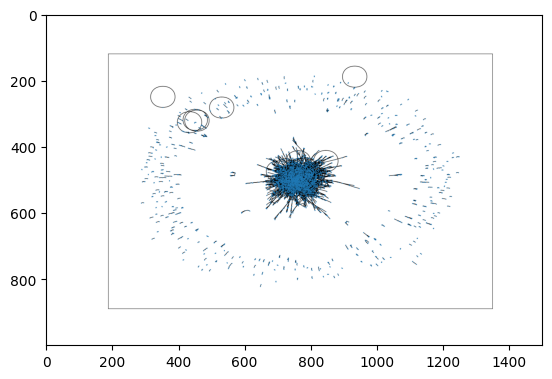

In [6]:
img = mpimg.imread('figures/graph_with_edges.png')
imgplot = plt.imshow(img)
plt.show()

### Degree Distribution

A degree distribution is a degree scatter plot, the degree on the x-axis and the number of nodes on the y-axis.

Commonly, one would normalise the y-axis by dividing its values by the number of nodes in the network, and the y-axis is the probability if a node to have a degree equal to k.

Generate a csv file containing the node and the corresponding degree of that node, and save it into the data folder as node_list_degrees.

In [7]:
#node_df2 = pd.DataFrame(sorted(dict(nx.degree(G)).items()))
#node_df2.rename(columns={0:"Node_id",1:"Degree"}, inplace=True)
#node_df2.to_csv("data/node_list_degrees.csv", index=False)

/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


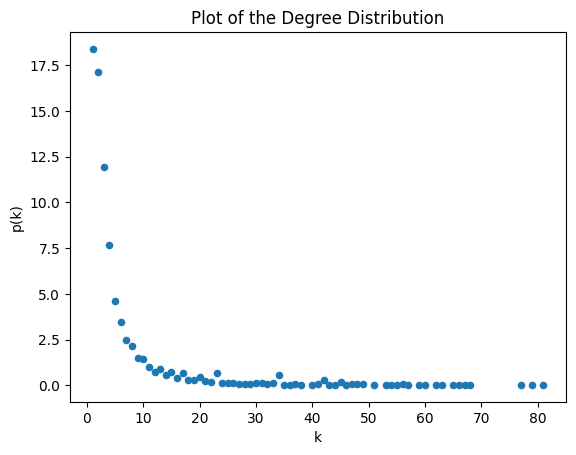

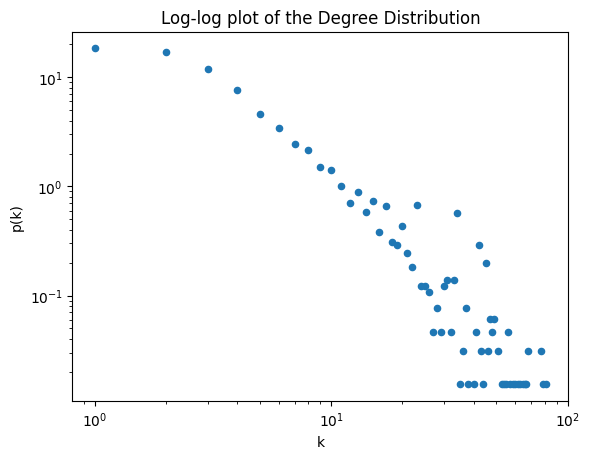

In [8]:
node_list_degrees = pd.read_csv("data/node_list_degrees.csv")

df_degrees = degree.make_df(node_list_degrees)

degree.plot_degree(df_degrees)

degree.plot_degree_log(df_degrees)


### The CCDF of the degree distribution (the complement of a cumulative distribution function)
The most common way to visualize degrees is by drawing cumulative distributions (CDF)

To make the CCDF we need to know how many nodes have degree equal to, or higher than a specific value. So we sort the dataframe in descending degree order, so that the pandas cumsum function will calculate that for us. Then we normalize by the total degree sum, so that the count becomes a probability. We then sort in ascending degree value, to respect the convention.

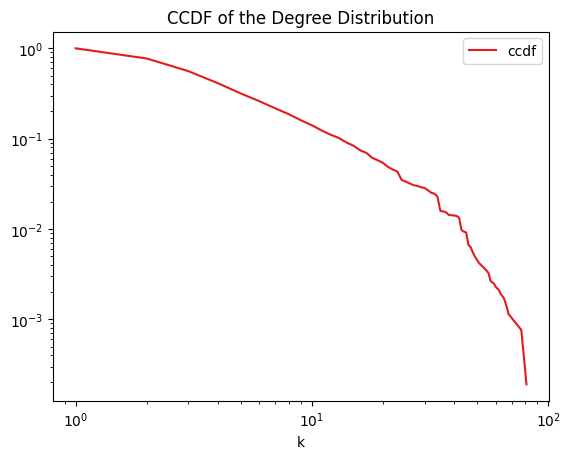

In [9]:
CCDF(df_degrees)

Description of CCDF

y: the probability of finding a node of degree k or higher

x: degree

CCDF Fit: 8.6089 x ^ -1.8811 (R2 = 0.8639, p = 0.0000)


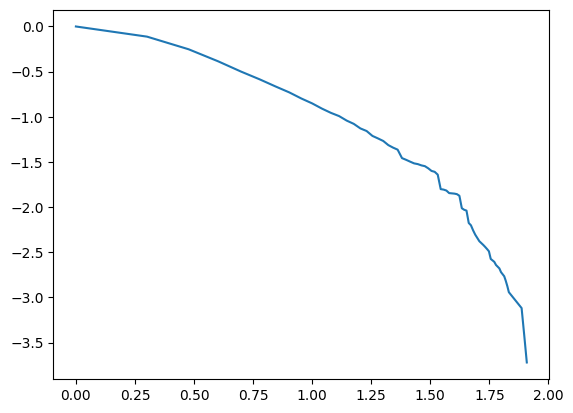

Calculating best minimal value for power law fit
/opt/conda/lib/python3.8/site-packages/powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/opt/conda/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Powerlaw CCDF Fit: 10.5617 x ^ -1.5297 (k_min = 6)
(0.23726641528943537, 0.0001907668828691339, 1.0378376800555995)
1.5296739039766996


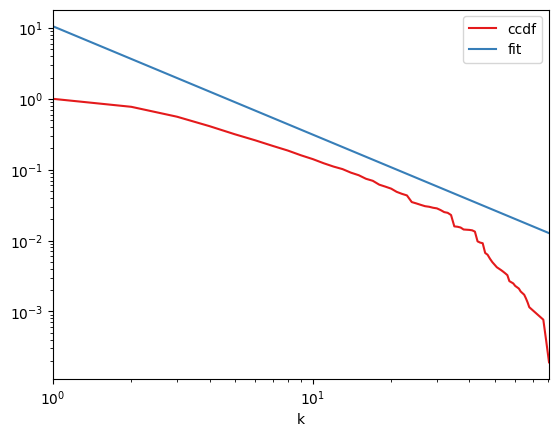

In [10]:
degree.check_power_law(G);

<AxesSubplot: xlabel='k', ylabel='p(k)'>

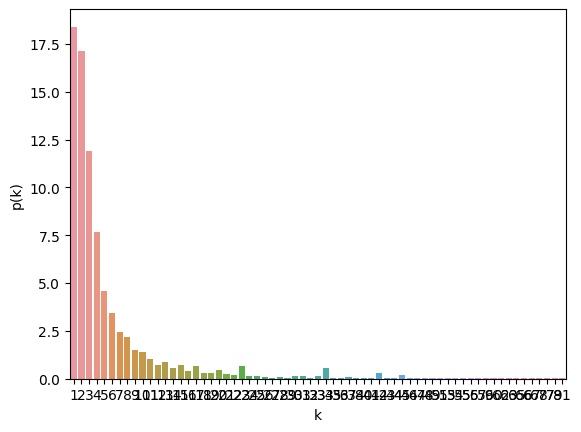

In [22]:
xs = np.linspace(0, 80, 100)
sns.barplot(data = df_degrees, x = 'k', y = 'p(k)')
sns.lineplot(xs, )


0      4.600000
1     18.400000
2      3.461538
3      7.646154
4      0.061538
        ...    
60     0.015385
61     0.015385
62     0.015385
63     0.015385
64     0.030769
Name: p(k), Length: 65, dtype: float64

## Connected Components

Our network consists of several connected components. Ideally we would like to have a network that is one connected component. Lets have a look at the connected components in the network, to see if we can argue for only working with the largest connected component of the network. 

In [11]:
# Find the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
LG = G.subgraph(largest_cc)

# Lets see how many percent the largest connected component make up - in terms of nodes. 
LG_no_nodes = nx.number_of_nodes(LG)

procentage = LG_no_nodes*100/no_nodes
print(f"Largest component procentage of the whole graph: {round(procentage, 2)}%")

list_of_all_components = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print(f"Number of components without the biggest is {len(list_of_all_components)-1}, where the size range is from {min(list_of_all_components)} to {max(list_of_all_components[1:])}")


Largest component procentage of the whole graph: 79.32%
Number of components without the biggest is 354, where the size range is from 1 to 14


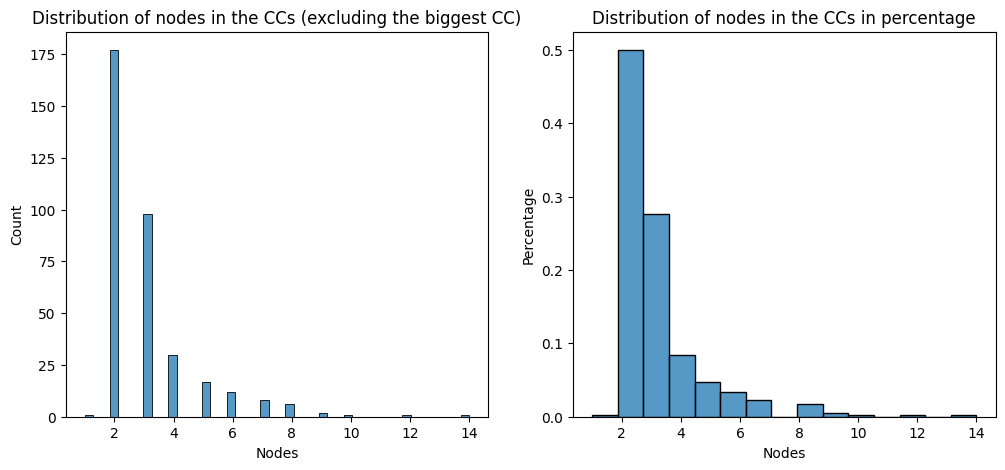

In [12]:
# Lets see the distribution of degrees in the connected components exluding the biggest one. And also where we normalise. 

fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(list_of_all_components[1:], ax=axs[0])
axs[0].set(title='Distribution of nodes in the CCs (excluding the biggest CC)', xlabel='Nodes')
# Weighting each data with 1/n in order to show proportion.
sns.histplot(x=list_of_all_components[1:], ax=axs[1], weights=np.ones(len(list_of_all_components[1:])) / len(list_of_all_components[1:]) , bins = 15)
axs[1].set(title='Distribution of nodes in the CCs in percentage', xlabel='Nodes', ylabel='Percentage');


Looks like the a lot of our connected components are between 2 and 4 people. It seems reasonable to focus only on the largest connected component. Lets look at a summary the largest connected component, that is now the network we will focus on. 

Using the script we obtain the following numerical description of the network. Read more in the metrics document. 

In [13]:

%%script echo skipping
summary.final_return_statement(LG, 5)

skipping


### Check for Power-law

Many networks have a power law degree distribution, but rarely this is a pure power law: it is often shifted or truncated. Fitting a power law and finding the correct exponent is tricky and you should not do it using a linear regression.

$p(k) \sim k^{-\alpha}$

Lets see if it changes anything for the power law, that we are only looking at the largest CC

/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


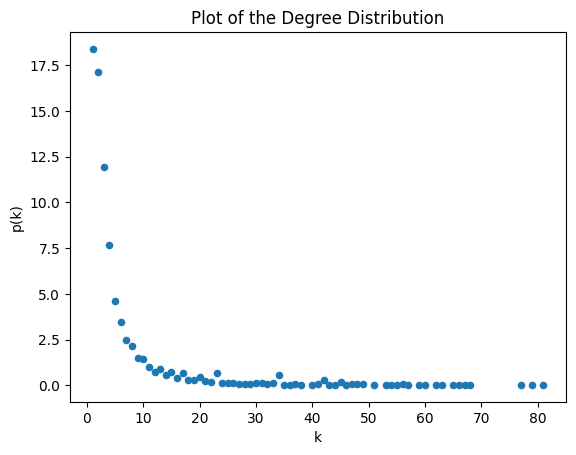

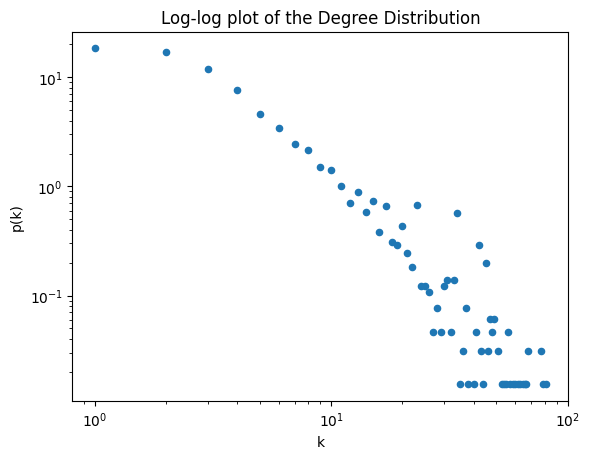

In [14]:
#node_dfCC = pd.DataFrame(sorted(dict(nx.degree(G)).items()))
#node_dfCC.rename(columns={0:"Node_id",1:"Degree"}, inplace=True)
#node_dfCC.to_csv("data/node_list_degreesCC.csv", index=False)

node_list_degrees = pd.read_csv("data/node_list_degreesCC.csv")

df_degrees = degree.make_df(node_list_degrees)

degree.plot_degree(df_degrees)

degree.plot_degree_log(df_degrees)

CCDF Fit: 9.8165 x ^ -1.8531 (R2 = 0.8543, p = 0.0000)


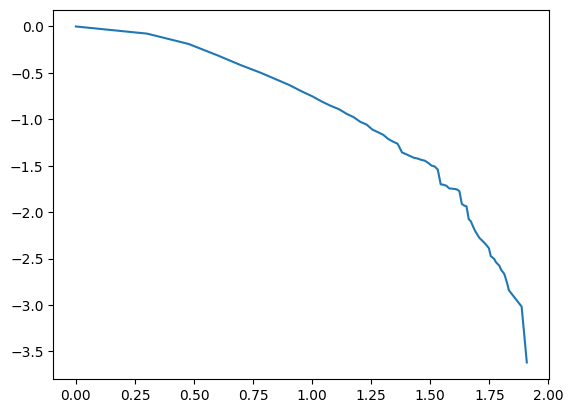

Calculating best minimal value for power law fit
/opt/conda/lib/python3.8/site-packages/powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/opt/conda/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Powerlaw CCDF Fit: 10.5193 x ^ -1.7202 (k_min = 5)
(0.26563660333014044, 0.00024050024050024048, 1.1436763605298759)
1.720166795512212


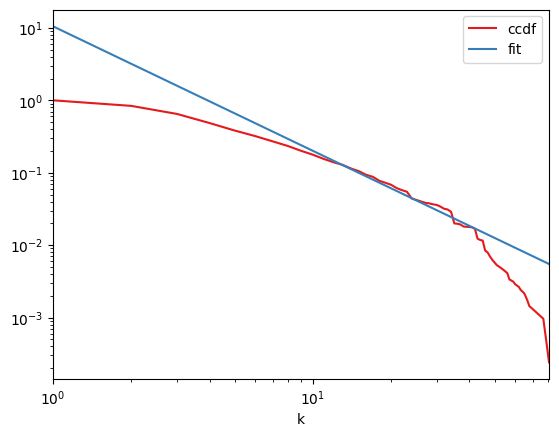

In [15]:
degree.check_power_law(LG);

Hmm doesn't change a lot - still doesn't follow Power Law. However, still a broad distribution. 

**Broad distribution**
Broad distribution, spanning multiple orders of magnitude. Most nodes have below-average degree and hubs lie many standard deviations above the average. 

**Shifted Power Law** 
Looks like a shifted power law, in the first part: "Shifted power laws practically mean that “Getting the first $k_{min}$ connections is easy”. If you go and sign up for Facebook, you generally already have a few people you know there. Thus we expect to find fewer nodes with degree 1, 2, or 3 than a pure power law would predict. The main takeaway is that, in a shifted power law, we find fewer nodes with low degrees than we expect in a power law." (SNA p.107) Or if you write a book/research paper with other people in physics, it is typically in groups with more than 2 people. 

**Truncated Power Law**
Also looks truncated; "Truncated power laws are typical of systems that are not big enough to show a true scale free behavior. There simply aren’t enough nodes for the hubs to connect to, or there’s a cost to new connections that gets prohibitive beyond a certain point. This is practically a power law excluding its tail, that’s why we call them “truncated”. Truncated power laws practically mean that “Getting the last connections is hard”" (SNA p.107)
I.e. it is hard to get a lot of coauthors. The author with the most coauthors has a lot of coauthors, but relatively speaking they are not that many more than the author with the second most coauthors.





### Path Length Distribution

The path length distribution provides information about the connectivity of our network. 

In [16]:
'''
There are V*(V-1) shortest paths to compute - a lot. So i save it in a json file,
such that we don't need to run the algorithm every time. 
'''
#path_lengths = dict(nx.all_pairs_shortest_path_length(LG))

#json_path_lengths = json.dumps(path_lengths)

# open file for writing, "w" 
#f = open("path_lengths.json","w")

# write json object to file
#f.write(json_path_lengths)

# close file
#f.close()

"\nThere are V*(V-1) shortest paths to compute - a lot. So i save it in a json file,\nsuch that we don't need to run the algorithm every time. \n"

In [17]:
with open('data/path_lengths.json', 'r') as f:
  data = json.load(f)

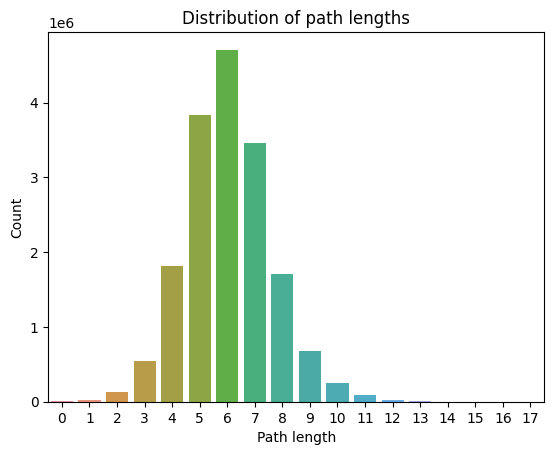

In [18]:
# Helper function to get all values of a nested dictionary 
def NestedDictValues(d):
  for v in d.values():
    if isinstance(v, dict):
      yield from NestedDictValues(v)
    else:
      yield v

path_lengths = list(NestedDictValues(data)) # now we have a list of all path lengths 
count_len = Counter(path_lengths) # Counter dict. Key(path length): value(count)

# Lets plot the result - using barplot since we already have the counts. 
g = sns.barplot(x=list(count_len.keys()), y=list(count_len.values()))
g.set(title='Distribution of path lengths', xlabel="Path length", ylabel="Count");

# NOTICE; The counts on the y-axis is in terms of y-axis multiplied by 10^6. 

Looks like a normal distribution - this was expected. Lets look at some more on the distribution of the path lengths. From the summary we know the average shortest path length to be  6.049380016182999. Let's calculate the standard deviation as well to see how tight the distribution is. 

In [19]:
print(f'Standard deviation: {np.std(path_lengths)}')

Standard deviation: 1.572959503409123


Seems like a tight distribution. 

## Degree Assortativity  

Degree assortativity is a global metric, that tells us whether nodes with high degrees tends to have edges to other nodes with high degrees (then the degree assortativity is close to 1). Or if nodes with high degree tend to have edges to nodes with low degree. (then metric is close to -1). 

In relation to our network, whether
- Authors who have written books with many other authors, tend to write books with authors, who also have written books with many other authors.
or 
- Authors who have written books with many other authors, tend to write books with authors, who have written books with only a few other authors.  

We obtain this metric by calculating the Pearson correlation between two vectors. The two vectors are vectors of degrees and for the same index in the vectors is the degree of one node in one vector and the degree of the node's neighbour in the other. 

In [20]:

print(f'Degree assortativity for the largest connected component: {nx.degree_pearson_correlation_coefficient(LG)}')

Degree assortativity for the largest connected component: 0.638997139962069
